In [1]:
import numpy as np
def BB(w0,wt,t,m):
    h = 2**m
    T = np.linspace(0,t, h+1)
    W = np.zeros(h+1)
    z = np.random.randn(h+1)
    W[0] = w0
    W[h] = wt
    j_max = 1
    
    for k in range(1, m+1):
        i_min = h//2
        i = i_min
        l = 0
        r = h
        for j in range(1, j_max+1):
            a = ((T[r]-T[i])*W[l] + (T[i]-T[l])*W[r]) / (T[r]-T[l])
            b = np.sqrt( (T[i]-T[l])*(T[r]-T[i])/(T[r]-T[l]) )
            W[i] = a + b*z[i]
            # print("i={}, left={}, right={}".format(i,l,r))
            i+=h; l+=h; r+=h
        j_max*=2
        h = i_min
    
    return W

In [2]:
import numpy as np
def control_variable(r,q1,q2,sigma1,sigma2,rho,M,m):

    S1_start = 100
    S2_start = 100
    principal = 100    
    
    T = 2
    check_term = 0.5
    check_max = int(T / check_term)
    
    case=6
    S1 = np.zeros(check_max+1)
    S2 = np.zeros(check_max+1)
    Put1 = np.zeros(check_max)
    Put2 = np.zeros(check_max)
    digital = np.zeros(check_max)
    X = np.zeros([M, check_max*5])
    Y = np.zeros(M)
    prob = np.zeros(case)
    
    for i in range(M):
        
        S1[0] = S1_start
        S2[0] = S2_start
        
        x1 = np.random.randn(check_max)
        x2 = np.random.randn(check_max)
        W1 = np.zeros(check_max+1)
        W2 = np.zeros(check_max+1)

        check_barrier = False
        
        for j in range(1, check_max+1):

            # Random walk
            W1[j] = W1[j-1] + np.sqrt(check_term) * x1[j-1]
            W2[j] = W2[j-1] + np.sqrt(check_term) * x2[j-1]
            
            e1 =  W1[j] - W1[j-1]
            e2 = rho*e1 + (W2[j] - W2[j-1])*np.sqrt(1-rho**2)
    
            # Get S1, S2 price at early redemption time
            S1[j] = S1[j-1]*np.exp( (r - q1 - (sigma1**2)/2)*check_term + sigma1*e1)
            S2[j] = S2[j-1]*np.exp( (r - q2 - (sigma2**2)/2)*check_term + sigma2*e2)
            
            # Get Put1, Put2 price at early redemption time
            Put1[j-1] = max(S1_start * (0.85 -0.05*(j-1)) - S1[j] ,0)
            Put2[j-1] = max(S2_start * (0.85 -0.05*(j-1)) - S2[j] ,0)
            
            # Get digital option price at early redemption time
            if (S1[j] >= S1_start * (0.85 - ((j-1) * 0.05))) and (S2[j] >= S2_start * (0.85 - ((j-1) * 0.05))):
                digital[j-1] = 1
            else:
                digital[j-1] = 0
            
            X[i][j-1] = S1[j]
            X[i][j+3] = S2[j]
            X[i][j+7] = Put1[j-1]
            X[i][j+11] = Put2[j-1]
            X[i][j+15] = digital[j-1]
            
            
        for j in range(1, check_max+1):
            
            # Check Barrier
            if (S1[j] < S1_start * 0.6) or (S2[j] < S2_start * 0.6):
                check_barrier = True
            
            # Check early repayment
            if (S1[j] >= S1_start * (0.85 - ((j-1) * 0.05))) and (S2[j] >= S2_start * (0.85 - ((j-1) * 0.05))):
                Y[i] = principal * (1+0.0625*j) * np.exp(-r * j * check_term)
                prob[j-1]+=1
                break
            
            # Check Maturity repayment
            if j == check_max:
                if (check_barrier == True) and ( (S1[j] < S1_start * 0.7) or (S2[j] < S2_start * 0.7) ):
                    Y[i] = principal * min(S1[j]/S1_start, S2[j]/S2_start) * np.exp(-r * j * check_term)
                    prob[j+1]+=1
                    break
                    
                else:
                    S1_BB = np.zeros(2**m+1)
                    S2_BB = np.zeros(2**m+1)
                    S1_BB[0] = S1_start
                    S2_BB[0] = S2_start
                    
                    # Brownian Bridge
                    for k in range(1, check_max+1):      
                        W1_BB = BB(W1[k-1], W1[k], 0.5, m)
                        W2_BB = BB(W2[k-1], W2[k], 0.5, m)
                        
                        for l in range(1, 2**m+1):
                            e1 = W1_BB[l] - W1_BB[l-1]
                            e2 = rho*e1 + (W2_BB[l] - W2_BB[l-1]) * np.sqrt(1-rho**2)
                        
                            S1_BB[l] = S1_BB[l-1] * np.exp( (r - q1 - sigma1**2/2)*(check_term/2**m) + sigma1 * e1 )
                            S2_BB[l] = S2_BB[l-1] * np.exp( (r - q2 - sigma2**2/2)*(check_term/2**m) + sigma2 * e2 )
                        
                        if any(S1_BB < S1_start * 0.6) or any(S2_BB < S2_start * 0.6):
                            check_barrier = True
                    
                        if (check_barrier == True) and ( (S1[j] < S1_start * 0.7) or (S2[j] < S2_start * 0.7) ):
                            Y[i] = principal * min(S1[j]/S1_start, S2[j]/S2_start) * np.exp(-r * j * check_term)
                            prob[j+1]+=1
                            break
                        else:        
                            S1_BB[0] = S1_BB[2**m]
                            S2_BB[0] = S2_BB[2**m]
                    
                    if (check_barrier == False) and ( (S1[j] < S1_start * 0.7) or (S2[j] < S2_start * 0.7) ):
                        Y[i] = principal * np.exp(-r * j * check_term)
                        prob[j]+=1
                        break
        
    return Y,X

r=0.03
q1=0.0
q2=0.0
sigma1=0.3
sigma2=0.4
rho=0.2
M=100000
m=3
Y,X=control_variable(r,q1,q2,sigma1,sigma2,rho,M,m)
corr=np.zeros(20)
for i in range(20):
    a=np.column_stack((Y,X[:,i]))
    corr[i]=np.corrcoef(a,rowvar=False)[0,1]
print('        t=0.5   t=1.0   t=1.5   t=2.0')
print('S1     ',end='')
for i in range(4):
    print('{:{width}.4f}'.format(corr[i],width=7),end=' ')
print(' ')
print('S2     ',end='')
for i in range(4,8):
    print('{:{width}.4f}'.format(corr[i],width=7),end=' ')
print(' ')
print('put1   ',end='')
for i in range(8,12):
    print('{:{width}.4f}'.format(corr[i],width=7),end=' ')
print(' ')
print('put2   ',end='')
for i in range(12,16):
    print('{:{width}.4f}'.format(corr[i],width=7),end=' ')
print(' ')
print('digital',end='')
for i in range(16,20):
    print('{:{width}.4f}'.format(corr[i],width=7),end=' ')
print(' ')


        t=0.5   t=1.0   t=1.5   t=2.0
S1      0.2662  0.2869  0.2875  0.2779  
S2      0.3610  0.3781  0.3710  0.3551  
put1   -0.3163 -0.3968 -0.4274 -0.4247  
put2   -0.4504 -0.5654 -0.6034 -0.6050  
digital 0.4776  0.4972  0.5330  0.5760  


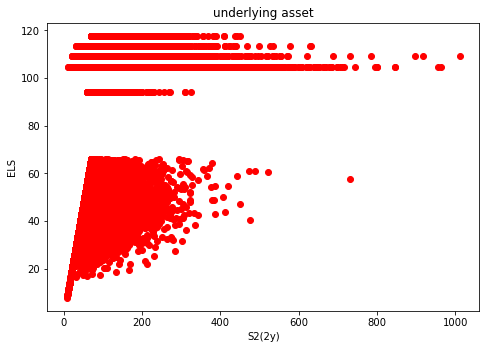

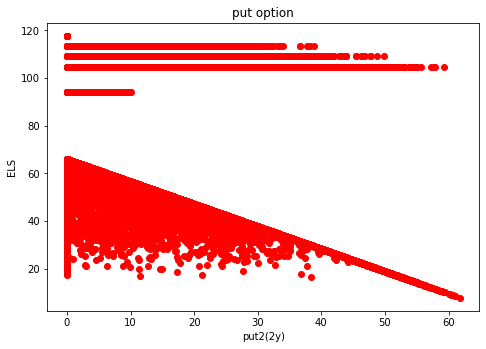

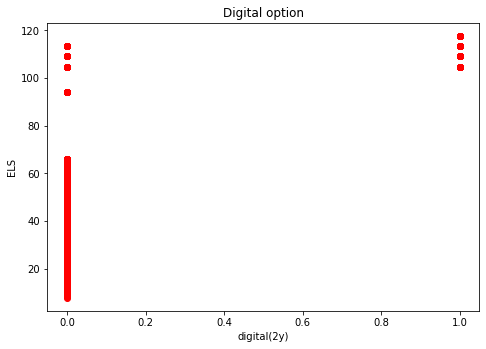

In [3]:
import matplotlib.pyplot as plt
fig=plt.figure()
ax=fig.add_axes([0,0,1,1])
ax.scatter(X[:,7], Y, color='r')
ax.set_xlabel('S2(2y)')
ax.set_ylabel('ELS')
ax.set_title('underlying asset')
plt.show()
fig=plt.figure()
ax=fig.add_axes([0,0,1,1])
ax.scatter(X[:,15], Y, color='r')
ax.set_xlabel('put2(2y)')
ax.set_ylabel('ELS')
ax.set_title('put option')
plt.show()
fig=plt.figure()
ax=fig.add_axes([0,0,1,1])
ax.scatter(X[:,19], Y, color='r')
ax.set_xlabel('digital(2y)')
ax.set_ylabel('ELS')
ax.set_title('Digital option')
plt.show()

In [4]:
import numpy as np
from scipy.stats import norm
def BS_put(S,K,r,q,T,sigma):
    d1=(np.log(S/K)+(r-q+sigma**2/2)*T)/(sigma*np.sqrt(T))
    d2=d1-sigma*np.sqrt(T)
    return K*np.exp(-r*T)*norm.cdf(-d2)-S*np.exp(-q*T)*norm.cdf(-d1)
def ELS_control(r,q1,q2,sigma1,sigma2,rho,M,m):
    
    Y,X=control_variable(r,q1,q2,sigma1,sigma2,rho,M,m)
    
    k = np.where(Y >= 100 * 1.25 * np.exp(-r*2), 4, 
        np.where(Y >= 100 * 1.1875 * np.exp(-r*1.5), 3,
                np.where(Y >= 100 * 1.125 * np.exp(-r*1.0), 2,
                        np.where(Y >= 100 * 1.0625 * np.exp(-r*0.5), 1,
                                np.where(Y >= 100 * np.exp(-r*2), 5, 6)))))
    
    key, counts = np.unique(k, return_counts=True)
    prob = np.array(counts)
    
    value = np.mean(Y)
    err = np.std(Y) / np.sqrt(M)
    prob = prob / M
    
    mx = np.mean(X[:,15])
    EX = BS_put(100,70,r,q2,2,sigma2)
    b = np.sum((X[:,15] - mx) * (Y - value)) / np.sum((X[:,15] - mx)**2)
    
    corr = np.corrcoef(np.column_stack((Y,X[:,15])), rowvar=False)[0,1]
    
    value2 = value - b * (mx - EX)
    err2 = err * np.sqrt(1-corr**2)

    return value,value2,err,err2,prob,b,mx,EX
from datetime import datetime
r=0.03
q1=0.0
q2=0.0
sigma1=0.3
sigma2=0.4
rho=0.2
M=10000
m=3
t1=datetime.now()
value,value2,err,err2,prob,b,mx,EX=ELS_control(r,q1,q2,sigma1,sigma2,rho,M,m)
t2=datetime.now()
print('value = {:.2f}, value2 = {:.2f}, err = {:.2f}, err2 = {:.2f}'.format(value,value2,err,err2))
for i in range(6):
    print('prob[{:d}] = {:{width}.2%}'.format(i+1,prob[i],width=6))
print('Total sum of prob = {:.0%}'.format(sum(prob)))
print('Total computing time = {:f} seconds'.format((t2-t1).total_seconds()))

value = 93.28, value2 = 93.79, err = 0.27, err2 = 0.21
prob[1] = 54.58%
prob[2] = 12.14%
prob[3] =  7.22%
prob[4] =  4.16%
prob[5] =  0.34%
prob[6] = 21.56%
Total sum of prob = 100%
Total computing time = 0.576038 seconds


In [5]:
b,mx,EX

(-1.3665033649691698, 6.40305327286263, 6.025617603963605)